# Projet Final de LLM - CARANGEOT Hugo, CONTE-DEVOLX Titouan - E5DSIA - 2024/2025 - ESIEE Paris

Dans un premier temps, rappelons rapidement le projet encadré par Monsieur Badr TAJINI, dans le cadre de l'unité LLM en 5ᵉ année d'ESIEE Paris.

"
**Project Summary**
This final project focuses on creating a basic AI assistant capable of following everyday instructions, built on
a GPT-2 model that is instruction-fine-tuned. The goal is to practice transforming a pretrained LLM (like
GPT-2) into a system that can respond effectively to various daily queries and tasks (e.g., scheduling
reminders, giving recipe suggestions, generating short emails).
You will leverage their understanding of pretraining, fine-tuning, and, most importantly, instruction-based
fine-tuning developed across the course (Chapters 5, 6, and 7). The project also draws on the methodology
seen in Labs 6-7, where a dataset was prepared for supervised instruction fine-tuning using an Alpaca-style
prompt format. By the end of this project, you will have a working prototype of a GPT-2–based assistant,
demonstrating how instruction fine-tuning can dramatically improve the model’s ability to follow user
commands and prompts
" *(c.f. final-project-llms-2025.md, Teams)*

Nous allons suivre étape par étape les consignes pour ce notebook, à savoir : 

1) *'Environment Setup & Base Model Initialization'*
2) *'Instruction Dataset Preparation'*
3) *'Instruction Fine-Tuning'*
4) *'Evaluation & Iterative Improvement'*
5) *'Deployment & Final Presentation'*

L'objectif final étant d'avoir un assistant personnel et de le démontrer.

Enfin, nous allons utiliser des fonctions tirées du cours afin d'accélérer le temps de développement du projet.

## 1 - *'Environment Setup & Base Model Initialization'*

#### Important !

On ne dispose que d'une carte **NVIDIA GTX 1660ti 6Go**, cela n'était clairement pas suffisant pour entrainer notre modèle (que l'on verra par la suite) puisque nous avions des **OOM** [Out Of Memory error] malgré le réglage des paramètres. On a donc fait le tour de différents **services cloud** pour entrainer notre modèle avec des **GPU** plus **performants**. La meilleure offre que l'on a trouvée est celle de **<a href=https://www.kaggle.com>Kaggle</a>**. Nous disposons de **30h** par **semaine** de **GPU** **gratuitement** (avec 12h de session maximum). Ainsi pour entrainer notre modèle, nous avons utilisé en **parallèle deux GPU tesla T4** (on avait au choix : GPU T4 x 2; GPU P100; TPU VM v3-8) ce qui nous a dans un premier temps, tout simplement permis d'entrainer notre modèle qui est un peu lourd et en plus de le faire rapidement grâce à l'utilisation parallèle des deux GPU T4 offerts par Kaggle.

Pour utiliser Kaggle, nous devons importer nos fichiers locaux sur l'interface Web (nous avons déjà créé un dataset contenant nos fichiers python...) et les rendre utilisables en les mettant dans le dossier **working**.

In [1]:
import shutil
import os

# Créer le dossier cible s'il n'existe pas
os.makedirs("/kaggle/working/projet", exist_ok=True)

# Copier tous les fichiers depuis /kaggle/input/vers /kaggle/working/projet/
shutil.copytree("/kaggle/input/librairies-hugo-llm-final-project", "/kaggle/working/project", dirs_exist_ok=True)

print("Fichiers et dossiers copiés dans /kaggle/working/project/")

Fichiers et dossiers copiés dans /kaggle/working/project/


In [2]:
import os

# Lister les fichiers dans le répertoire de travail actuel
print(os.listdir("/kaggle/working/project"))

['gpt_instruction_finetuning.py', 'previous_labs.py', 'gpt_download.py']


In [3]:
import sys
sys.path.append("/kaggle/working/project")

Maintenant que nous avons importé nos différents fichiers, commençons le projet.
Importons notre modèle GPT-2. Nous utiliserons la version medium (355M param) pour un meilleur rendu final même si plus lourd au fine-tuning.

In [7]:
from gpt_download import download_and_load_gpt2
from previous_labs import GPTModel, load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2\355M\checkpoint
File already exists and is up-to-date: gpt2\355M\encoder.json
File already exists and is up-to-date: gpt2\355M\hparams.json
File already exists and is up-to-date: gpt2\355M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\355M\model.ckpt.index
File already exists and is up-to-date: gpt2\355M\model.ckpt.meta
File already exists and is up-to-date: gpt2\355M\vocab.bpe


Vérifions ensuite que notre modèle est bien importé et fonctionnel en lui faisant générer du texte, la phrase générée doit avoir du sens pour affirmer que notre modèle est bien instancié.

In [8]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

In [9]:
import torch
from previous_labs import generate, text_to_token_ids, token_ids_to_text

torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Translate in french: Hello World !", tokenizer),
    max_new_tokens=25,
    context_size=BASE_CONFIG["context_length"],
    top_k=25,
    temperature=0.8
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Translate in french: Hello World !

This is a quick tutorial on translating a simple web application into another native language.

You can find the source


Le texte généré a du sens même s'il ne répond pas au problème (c'est pour cela qu'on va le fine-tuner), ce qui prouve que notre modèle a été correctement chargé.

Enfin, pour réduire radicalement le temps "d'entrainement" (ici, c'est plus du fine-tuning) de notre modèle, nous utiliserons les deux GPU T4 et les ferons tourner parallèlement. 

In [7]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

model.to(device)

print(f"Utilisation de {torch.cuda.device_count()} GPUs")

Utilisation de 2 GPUs


## 2 - *'Instruction Dataset Preparation'*

Nous avons bien compris qu'il est **compliqué** de **créer un assistant** très **généraliste performant**, surtout pour les petits modèles que nous entraînons. Il est donc préférable de concevoir plusieurs **assistants spécialisés** dans des tâches spécifiques. Ici, nous nous concentrerons sur la création d’un **assistant dédié à la traduction de l'anglais au français**.

Pour cela, nous utiliserons le dataset **<a href=https://huggingface.co/datasets/FrancophonIA/English-French>FrancophonIA/English-French</a>**.
La **longueur maximale** des textes en **anglais** est de **262** caractères, tandis que celle des textes en **français** est de **325** caractères. Cependant, la longueur en tokens peut différer (et c'est même presque toujours le cas), car un caractère ne correspond pas systématiquement à un token.

### Gestion des tokens

D'après **OpenAI** (c.f. https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them):

    "1,500 words ~= 2048 tokens"

Ce qui donne une approximation de **1024 tokens ≈ 750 mots**.

Notre dataset suit le format **Parallel Corpus** (**Anglais** ↔ **Français** pour chaque ligne), ce qui est idéal pour fine-tuner notre modèle. Cependant, **GPT-2** est pré-entraîné sur du **texte brut**, donc nous devons concaténer les entrées et sorties en une seule séquence pour respecter ce format.

### Longueurs des mots et tokenization

Après une courte recherche sur Google, nous trouvons:

- **Anglais** : ~**4.7** caractères/mot
- **Français** : ~**5.1** caractères/mot

Si l'on considère une moyenne de 5 caractères par mot, alors une phrase combinant un texte en anglais (262 caractères) et un texte en français (325 caractères) représente environ :

(262 + 325)/5 ~= 118 mots ~ 161 tokens 

### Dépassement du max_length de 1024 tokens

Nous sommes donc largement **sous** la **limite** des **1024** tokens. Cela signifie que nous pouvons ajouter des consignes via du **prompt engineering** pour **améliorer** l'**entraînement** du modèle sans dépasser cette contrainte.

Si certaines réponses venaient à dépasser cette limite, nous appliquerons une **troncature**, bien que ce cas soit peu probable, car le modèle **BPE** utilisé par **GPT-2** segmente efficacement les mots fréquents.

Comme nous avons pris un dataset sur **HuggingFace**, il existe une libraire python 'datasets' pour l'importer directement.

In [37]:
import datasets
import tqdm

dataset = datasets.load_dataset("FrancophonIA/English-French")

In [38]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['English words/sentences', 'French words/sentences'],
        num_rows: 175621
    })
})


In [39]:
print(dataset["train"][0])  

{'English words/sentences': 'Hi.', 'French words/sentences': 'Salut!'}


Nous avons fait un tour rapidement de quelques lignes pour s'assurer qu'elles étaient **bien rédigées**, etc. Il y a **175,621 lignes** ce qui permet une **traduction** assez **complète**. De plus, "author only used sentences that were owned by identified native speakers working on the Tatoeba Project and English sentences that he personally checked and did not reject." (c.f. https://www.kaggle.com/datasets/devicharith/language-translation-englishfrench).
Nous avons donc un **indice de confiance élevé** pour ce **dataset**.

Nous allons également séparer nos données en sets train, test, validation puisqu'ils n'existent pas de base.

In [40]:
data = dataset['train'].shuffle(seed=123)

# On définit nos portions
train_portion = int(len(data) * 0.80)
val_portion = int(len(data) * 0.10)

# Séparation en train (80%), validation (10%) et test (10%)
train_data = data.select(range(train_portion))
val_data = data.select(range(train_portion, train_portion + val_portion))
test_data = data.select(range(train_portion + val_portion, len(data)))

In [41]:
print(len(train_data), len(val_data), len(test_data))
print(train_data[0])

140496 17562 17563
{'English words/sentences': "I'll try to do better next time.", 'French words/sentences': "J'essayerai de faire mieux la prochaine fois."}


On voit bien la répartition des différents ensembles.

Concaténons les questions et réponses en une seule phrase pour obtenir notre texte brut pour le fine-tuning. Appliquons également du **Prompt Engineering** pour aligner notre modèle sur nos attentes et optimiser ses performances.  

Pour cela, définissons :  
- **Un rôle** pour guider son comportement,  
- **Une tâche** pour préciser l’objectif,  
- Enfin, **la question et la réponse**, afin qu’il apprenne le format attendu.

In [13]:
from torch.utils.data import Dataset, DataLoader

class TranslationDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
        self.encoded_texts = []

        # Tokenisation des données avec un rôle explicite
        for entry in data:
            instruction = (
                "\n\n### Role: You are a translation assistant."
                "\n### Task: Translate the given English sentence into French."
                f"\n### English Sentence:\n{entry['English words/sentences']}"
            )
            response = f"\n\n### French Translation:\n{entry['French words/sentences']} <|endoftext|>"

            full_text = instruction + response
            self.encoded_texts.append(
                self.tokenizer.encode(full_text, allowed_special={"<|endoftext|>"})
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

Par ailleurs, créons des batchs de taille dynamique (plus grande entrée ou 1024 max) afin d'améliorer notre entraînement.

In [14]:
from functools import partial
from gpt_instruction_finetuning import custom_collate_fn

customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

Maintenant, il ne reste plus qu'à en faire des data loaders.

In [15]:
num_workers = 0 # CPU trop faible pour +
batch_size = 16  # bas pour éviter OOM

train_dataset = TranslationDataset(train_data, tokenizer=tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = TranslationDataset(val_data, tokenizer=tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

test_dataset = TranslationDataset(test_data, tokenizer=tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

## 3 - *'Instruction Fine-Tuning'*

Il est maintenant temps de lancer "l'apprentissage" de notre modèle !

Le learning rate est de 5e-5, ce qui est souvent utilisé pour le fine-tuning d'un modèle pré-entrainé comme GPT-2.

Le batch_size est de 16, nous avons commencé à 32, mais ne disposions pas d'assez de mémoire (OOM).

Nous avons également mis 2 epochs, c'est une valeur souvent utilisée pour fine-tuner en évitant de trop sur-apprendre et pour ne pas entrainer pendant trop longtemps (l'entrainement a pris presque 6h sur Kaggle, il aurait fallu près de 54 jours sur notre ordinateur).

In [16]:
from previous_labs import train_model_simple

import time

start_time = time.time()

torch.manual_seed(123)

num_epochs = 2
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
model.to(device)

train_losses, val_losses, tokens_seen = train_model_simple(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader, 
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=500,
    eval_iter=100,
    start_context=val_data[0]["English words/sentences"],
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.546, Val loss 2.550
Ep 1 (Step 000500): Train loss 0.737, Val loss 0.745
Ep 1 (Step 001000): Train loss 0.634, Val loss 0.659
Ep 1 (Step 001500): Train loss 0.611, Val loss 0.632
Ep 1 (Step 002000): Train loss 0.572, Val loss 0.585
Ep 1 (Step 002500): Train loss 0.531, Val loss 0.570
Ep 1 (Step 003000): Train loss 0.524, Val loss 0.552
Ep 1 (Step 003500): Train loss 0.507, Val loss 0.529
Ep 1 (Step 004000): Train loss 0.479, Val loss 0.524
Ep 1 (Step 004500): Train loss 0.474, Val loss 0.509
Ep 1 (Step 005000): Train loss 0.465, Val loss 0.507
Ep 1 (Step 005500): Train loss 0.457, Val loss 0.497
Ep 1 (Step 006000): Train loss 0.452, Val loss 0.494
Ep 1 (Step 006500): Train loss 0.445, Val loss 0.494
Ep 1 (Step 007000): Train loss 0.431, Val loss 0.482
Ep 1 (Step 007500): Train loss 0.418, Val loss 0.487
Ep 1 (Step 008000): Train loss 0.408, Val loss 0.482
Ep 1 (Step 008500): Train loss 0.406, Val loss 0.479
She showed him the photo.  I'm not sure what t

On enregistre notre modèle pour le réutiliser par la suite.

In [17]:
torch.save(model, 'ft-model.pth')

In [18]:
from IPython.display import FileLink

display(FileLink("ft-model.pth"))

/kaggle/working/ft-model.pth

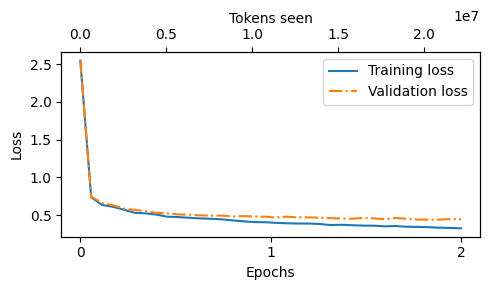

In [19]:
from previous_labs import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

On s'aperçoit que notre modèle **apprend très vite** au **début** puisqu'il passe d'un/e training/val loss de 2.5 à ~0.7 au tout début de la première epoch. Par la suite, nous remarquons que nos deux loss continuent de baisser jusqu'au milieu de l'epoch 1 à 2. Cependant, nous remarquons que sur la fin, notre training loss continue de descendre et notre validation loss stagne, cela reflète un **over fitting** (assez léger dans notre cas).

Nous pensons donc avoir mis des bons paramètres d'entrainement pour notre modèle.
Vérifions cela dans la prochaine partie.

## 4 - *'Evaluation & Iterative Improvement'*

Nous allons repasser en local (plus sur Kaggle) pour **évaluer** notre modèle grâce à la **perplexité** via **ollama -> llama3**.

#### Ici, nous allons recharger notre modèle avec les param d'entrainement enregistrés pour évaluer le modèle.

In [8]:
import torch

# Charger le modèle sauvegardé (sur plusieurs GPUs)
ft_model = torch.load('ft-model.pth', map_location="cuda")  # Charger sur un seul GPU

# Si le modèle est encapsulé dans DataParallel, on retire l'encapsulation
if isinstance(ft_model, torch.nn.DataParallel):
    ft_model = ft_model.module  # Récupérer le modèle original

device = torch.device("cuda")
ft_model.to(device)

C:\Users\hugoc\AppData\Local\Temp\ipykernel_21904\410182289.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ft_model = torch.load('ft-model.pth', map_location="cuda")  #

GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_f

In [9]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

Nous avons écrit un **code python** permettant d'utiliser notre modèle via un **CLI**. Nous avons également écrit une fonction pour **traduire** un texte **anglais** en **français** à l'aide de notre modèle. Vérifions que notre modèle fonctionne avant de calculer sa perplexité.

In [10]:
from translate import translate

torch.manual_seed(123)

text_to_translate = "i need a backpack"

translation = translate(text_to_translate, ft_model, tokenizer)
print(f"Traduction : {translation}\n")

Traduction : J'ai besoin d'un sac à dos.


**Faisons** toutes les **traductions** par notre modèle pour le **set de test** et **enregistrons** tout cela dans un **json** afin de pouvoir calculer la **perplexité** avec **ollama**.

In [24]:
print(test_data[:2])

{'English words/sentences': ['Tom hid behind a tree.', "Don't they drive you mad?"], 'French words/sentences': ['Tom se cacha derrière un arbre.', 'Ne vous font-elles pas tourner bourriques ?']}


In [43]:
test = [
    {'English words/sentences': eng, 'French words/sentences': fr} 
    for eng, fr 
    in zip(test_data['English words/sentences'], test_data['French words/sentences'])
]

In [44]:
print(test[:2])
print(test.__len__())

[{'English words/sentences': 'Tom hid behind a tree.', 'French words/sentences': 'Tom se cacha derrière un arbre.'}, {'English words/sentences': "Don't they drive you mad?", 'French words/sentences': 'Ne vous font-elles pas tourner bourriques ?'}]
17563


In [45]:
from tqdm import tqdm
import json

column_translated = []

for i, entry in tqdm(enumerate(test), total=len(test)):
    translation = translate(test[i]['English words/sentences'], ft_model, tokenizer)
    test[i]["model_response"] = translation

100%|██████████| 17563/17563 [3:57:56<00:00,  1.23it/s]  


In [46]:
with open("translate.json", "w", encoding='utf-8') as file:
    json.dump(test, file, indent=4, ensure_ascii=False)  # "indent" for pretty-printing

Nous avons dans un premier temps, installé **ollama** sur notre machine (en local) et avons forcé l'utilisation sur le **GPU** grâce au **panneau de configuration NVIDIA**.
Nous devons vérifier qu'il tourne pour pouvoir faire des appels dessus via notre code python.

In [48]:
from ollama_evaluate import check_if_running, generate_model_scores


ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


Maintenant que tout cela est fait, nous devons faire des appels sur ollama pour toutes les lignes de notre fichier. Nous obtiendrons un **score** sur une échelle de **0 à 100** avec 100 une réponse parfaite. Ollama donnera une note qui n'est pas basée que sur la correspondance des mots, puisque par exemple, si nous avons la traduction attendue 'Il fait très chaud aujourd'hui.' et que notre modèle traduit 'Aujourd’hui, il fait une chaleur intense.' cela demeure correct.

In [52]:
file_path = 'translate.json'

with open(file_path, "r") as file:
    json_data = json.load(file)

model = "llama3"
scores = generate_model_scores(json_data, "model_response", model)
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries: 100%|██████████| 17563/17563 [13:58:32<00:00,  2.86s/it]  

Number of scores: 17563 of 17563
Average score: 75.90


Nous obtenons un **score moyen** de **75.9**. 

Nous pensons que cela reflète un **excellent fine-tuning** puisque nous partons d'un modèle (**gpt2 M**) qui n'est **pas très performant de base**. Il n'y a que 355M de paramètres, ce qui fait que notre LLM peut avoir du mal à comprendre et interpréter, surtout que gpt2 n'a **pas** été **entrainé** sur du **français**. Ce score reflète globalement une bonne, voire une très bonne traduction. 

De ce que nous avons vu (nous l'avons testé via notre session CLI), le modèle fait très souvent des très bonnes traductions, parfois des traductions compréhensibles, mais avec des petites erreurs (e.g. il traduit 'what time is it ?' en 'A quelle heure il est ?' Cela est suffisant pour que nous le comprenions, mais n'est pas totalement juste. Et parfois, il n'arrive pas à traduire, si on lui met un mot inconnu par exemple, comme le prénom hugo ou titouan, vu que sur notre fonction generate, nous avons mis un petit topk (5) et une petite température (0.2), le modèle répond avec des mots dont la probabilité est importante.


Nous sommes globalement très satisfait de nos traductions réalisées via la LLM et nous vous invitons à regarder rapidement quelques lignes du fichier 'translate.json' pour voir les traductions sur notre ensemble de test.
Nous pensons que notre fine-tuning est suffisamment performant et ne nécessite pas d'être refait. Nous pourrions cependant chercher des paramètres plus 'optimaux' pour notre fonction generate (qui est dans translate).

Pour véritablement améliorer nos traductions, il faudrait surtout prendre un modèle de base plus performant.

## 5 - *'Deployment & Final Presentation'*

Comme nous l'avons dit auparavant, nous avons wrappé notre modèle pour l'utiliser dans une **session CLI**. Tout cela est disponible dans le fichier **'translate.py'**. Pour démarrer la session, ouvrez un terminal, rejoignez le dossier où se trouve le fichier et entrez : *python translate.py*. Cela ouvrira une 'session' que vous pourrez quitter via l'entrée d'*exit* ou de *quit*. Pour traduire, il suffira d'entrer le texte, par exemple : i need a backpack. Vous verrez la traduction juste en dessous (voir ci-dessous).

![CLI image](CLI.png)

Une vidéo de présentation des performances de notre modèle via ce script CLI a été réalisée et vous a été transmise.

Nous n'avons pas eu de difficulté de compréhension pour ce projet, cependant, il a été compliqué de faire tourner tous nos codes puisqu'ils prenaient du temps à compiler (bien que cela soit normal pour des LLM), notamment pour ollama, le code a pris 14h à tourner et nous avons dû le faire tourner plusieurs fois pour obtenir un résultat (pc qui surchauffe, etc).

Pour toutes autres questions n'hésitez pas à nous contacter sur nos mails étudiants ESIEE Paris.

Merci pour votre lecture,
Titouan et Hugo.